# Permutational Cellular Automata (PeCA) with *m* = 2 Playground  
**Author:** Joaquín Cerdá-Boluda  
**Model Reference:** *Permutational Cellular Automata: From Bitwise Reversibility to Quantum Dynamics*, Joaquín Cerdá-Boluda and Marta C. Mora  
**Version:** 1.0  
**Last update:** 5/11/2025  
[GitHub Repository](https://github.com/ximocerda/PermutationalCellularAutomata)

---


## Introduction

## 🔍 Introduction

This Colab notebook provides an interactive environment to explore **Permutational Cellular Automata (PeCA)** in the simplest non-trivial case: **2-bit cells**.

A PeCA is a class of **reversible cellular automata** where the **local update rule** is defined by a **permutation** over the possible bit configurations of a cell, and **intercellular connectivity** specifies how bits are exchanged between neighbors.

In this notebook, we focus on the case where each cell stores **2 bits** of state:
- These are denoted as `[l, r]`, representing the **left** and **right** segments (or bits).
- Each pair forms a state in the set {00, 01, 10, 11}, which has **4 possible values**.

The evolution of the automaton proceeds in two steps:
1. **Permutation Step**: A fixed permutation σ is applied to the 2-bit input, transforming it into a new 2-bit output.
2. **Connectivity Step**: The bits are redistributed across neighboring cells following the connectivity scheme:
   `[l, r] → [r(i–1), l(i+1)]`
   (as defined in Equation (16) of the paper)

This version uses a **1D lattice** of cells with **periodic boundary conditions**, and allows you to experiment with different rules (i.e., permutations), initial conditions, and time steps.

---
➡️ Let’s begin by implementing the **combinatorial encoding tools** that allow us to represent permutations efficiently.


In [ ]:
import math

# Conversion functions
def int_to_factoradic(n: int, N: int) -> list[int]:
    """Convert integer to its factoradic representation with N digits."""
    digits = [0] * N
    for i in range(1, N):
        digits[-i-1] = n % (i+1)
        n //= (i+1)
    digits[-1] = n
    return digits

def factoradic_to_int(factoradic: list[int]) -> int:
    """Convert a factoradic list to its integer value."""
    return sum(d * math.factorial(i) for i, d in enumerate(reversed(factoradic)))

def factoradic_to_permutation(factoradic: list[int]) -> list[int]:
    """Convert a factoradic number (Lehmer code) to a permutation."""
    elements = list(range(len(factoradic)))
    return [elements.pop(i) for i in factoradic]

def permutation_to_factoradic(perm: list[int]) -> list[int]:
    """Convert a permutation to its Lehmer code (factoradic)."""
    elements = list(range(len(perm)))
    factoradic = []
    for x in perm:
        idx = elements.index(x)
        factoradic.append(idx)
        elements.pop(idx)
    return factoradic

def int_to_permutation(n: int, N: int) -> list[int]:
    """Map an integer to a permutation via factoradic encoding."""
    factoradic = int_to_factoradic(n, N)
    return factoradic_to_permutation(factoradic)

def permutation_to_int(perm: list[int]) -> int:
    """Convert a permutation to its corresponding integer via factoradic."""
    factoradic = permutation_to_factoradic(perm)
    return factoradic_to_int(factoradic)

# Updated apply_rule function
def int_to_bits(x, m):
    """Convert integer to list of m bits."""
    return [(x >> i) & 1 for i in reversed(range(m))]

def bits_to_int(bits):
    """Convert list of bits to integer."""
    return sum(b << (len(bits)-1-i) for i, b in enumerate(bits))

def apply_rule(cell_bits, rule_number: int):
    """
    Apply a permutation rule given by rule_number (0–23) to a cell of 2 bits.
    """
    if len(cell_bits) != 2:
        raise ValueError("This rule only supports 2-bit cells (m=2).")
    if not (0 <= rule_number < math.factorial(4)):
        raise ValueError("Rule number must be between 0 and 23.")

    perm = int_to_permutation(rule_number, 4)
    idx = bits_to_int(cell_bits)
    new_idx = perm[idx]
    return int_to_bits(new_idx, 2)


### Conversion Checks
Before defining the global behavior of the PeCA, let us verify that the bit-level encoding functions work as expected.


In [ ]:
from IPython.display import Markdown

def print_test_result(title, expected, result):
    display(Markdown(f"**{title}**  \nExpected: `{expected}`  \nGot: `{result}`  \n{'✅' if expected == result else '❌'}"))

# 1. int_to_factoradic
n = 13
N = 4
expected_factoradic = [2, 0, 1, 0]  # Because 13 = 2×3! + 0×2! + 1×1! + 0×0!
result_factoradic = int_to_factoradic(n, N)
print_test_result("int_to_factoradic(13, 4)", expected_factoradic, result_factoradic)

# 2. factoradic_to_int
expected_int = 13
result_int = factoradic_to_int(expected_factoradic)
print_test_result("factoradic_to_int([2, 0, 1, 0])", expected_int, result_int)

# 3. factoradic_to_permutation
expected_perm = [2, 0, 3, 1]
result_perm = factoradic_to_permutation(expected_factoradic)
print_test_result("factoradic_to_permutation([2, 0, 1, 0])", expected_perm, result_perm)

# 4. permutation_to_factoradic
expected_factoradic_back = [2, 0, 1, 0]
result_factoradic_back = permutation_to_factoradic(expected_perm)
print_test_result("permutation_to_factoradic([2, 0, 3, 1])", expected_factoradic_back, result_factoradic_back)

# 5. int_to_permutation
expected_perm_from_int = [2, 0, 3, 1]
result_perm_from_int = int_to_permutation(13, 4)
print_test_result("int_to_permutation(13, 4)", expected_perm_from_int, result_perm_from_int)

# 6. permutation_to_int
expected_back_int = 13
result_back_int = permutation_to_int([2, 0, 3, 1])
print_test_result("permutation_to_int([2, 0, 3, 1])", expected_back_int, result_back_int)

# 7. apply_rule
test_cell_bits = [1, 0]  # binary 10 = index 2
rule_number = 13         # which maps permutation [2, 0, 3, 1]
# position 2 maps to 3 → binary 11
expected_bits_out = [1, 1]
result_bits_out = apply_rule(test_cell_bits, rule_number)
print_test_result("apply_rule([1, 0], rule 13)", expected_bits_out, result_bits_out)

**int_to_factoradic(13, 4)**  
Expected: `[2, 0, 1, 0]`  
Got: `[2, 0, 1, 0]`  
✅

**factoradic_to_int([2, 0, 1, 0])**  
Expected: `13`  
Got: `13`  
✅

**factoradic_to_permutation([2, 0, 1, 0])**  
Expected: `[2, 0, 3, 1]`  
Got: `[2, 0, 3, 1]`  
✅

**permutation_to_factoradic([2, 0, 3, 1])**  
Expected: `[2, 0, 1, 0]`  
Got: `[2, 0, 1, 0]`  
✅

**int_to_permutation(13, 4)**  
Expected: `[2, 0, 3, 1]`  
Got: `[2, 0, 3, 1]`  
✅

**permutation_to_int([2, 0, 3, 1])**  
Expected: `13`  
Got: `13`  
✅

**apply_rule([1, 0], rule 13)**  
Expected: `[1, 1]`  
Got: `[1, 1]`  
✅

### Global Evolution of PeCA with m = 2


In this section, we define the global evolution function for a Permutational Cellular Automaton (PeCA) with **2-bit cells**.


Each cell in the array contains two bits, and **the rule is a permutation over the 4 possible 2-bit configurations** (00, 01, 10, 11), represented as a number from 0 to 23 (using Lehmer code encoding).


The connectivity follows equation (16) in the paper, where the left bit of a cell at position `i` is taken from cell `i - 1`, and the right bit from cell `i + 1`, with periodic boundary conditions. As a result, **the configuration length must be even** (each cell occupies 2 bits).



In [ ]:

import numpy as np

def step_pe_ca_m2(config, rule_number):
    """
    Perform one step of PeCA evolution for m = 2.
    - config: list of bits (length must be even)
    - rule_number: integer between 0 and 23 (permutation index)
    Returns: new list of bits (same length)
    """
    if len(config) % 2 != 0:
        raise ValueError("Configuration length must be even (2 bits per cell)")

    num_cells = len(config) // 2
    if not (0 <= rule_number < 24):
        raise ValueError("Rule number must be between 0 and 23 (for m = 2)")

    # Get the permutation from the rule number
    rule_perm = int_to_permutation(rule_number, 4)
    new_config = [0] * len(config)

    for i in range(num_cells):
        # Determine neighbors with periodic BC
        left_idx = (i - 1) % num_cells
        right_idx = (i + 1) % num_cells

        # Construct the 2-bit input from neighbors
        l_bit = config[2 * left_idx + 1]   # right bit of left neighbor
        r_bit = config[2 * right_idx]     # left bit of right neighbor
        cell_bits = [l_bit, r_bit]

        # Apply rule
        new_bits = apply_rule(cell_bits, rule_number)
        new_config[2 * i] = new_bits[0]
        new_config[2 * i + 1] = new_bits[1]

    return new_config


Now we define the core functions for simulating and visualizing the evolution of a Permutational Cellular Automaton (PeCA) with m = 2 bits per cell. The evolution is governed by a local update rule defined as a permutation over the 4 possible 2-bit configurations. Each cell updates synchronously using inputs from its neighbors, based on the connectivity rule described in equation (16) of the paper.

*   **simulate_peca**: Simulates the evolution of a 1D PeCA over time, given a permutation rule and initial configuration.
*   **visualize_peca**: Displays the space-time evolution of the automaton, using one pixel per bit.

These tools allow quick experimentation with PeCA rules and visual inspection of the resulting behaviors.

In [ ]:
import matplotlib.pyplot as plt

def simulate_peca(rule_number, size=100, steps=100, init_state=None):
    """
    Simulate a PeCA with 2-bit cells using a rule number (0–23).
    - rule_number: integer index of permutation rule (0–23)
    - size: number of cells in the lattice
    - steps: number of time steps
    - init_state: optional list of 0s and 1s of length 2*size
    Returns: array of shape (steps, size, 2) with each cell's 2-bit state
    """
    if not (0 <= rule_number < 24):
        raise ValueError("rule_number must be between 0 and 23 (for m = 2)")

    if size % 1 != 0:
        raise ValueError("size must be an integer")

    full_length = 2 * size
    state = np.zeros((steps, full_length), dtype=int)

    if init_state is not None:
        if len(init_state) != full_length:
            raise ValueError("init_state must be of length 2 * size")
        state[0] = np.array(init_state)
    else:
        # Initial state: central cell set to [1,1]
        state[0, full_length // 2: full_length // 2 + 2] = 1

    for t in range(1, steps):
        state[t] = step_pe_ca_m2(state[t - 1].tolist(), rule_number)

    return state.reshape((steps, size, 2))



def visualize_peca(sim_data):
    """
    Display PeCA evolution as a raster plot. Each cell = 2 pixels.
    0 = white, 1 = black.
    """
    steps, size, _ = sim_data.shape
    img = np.zeros((steps, size * 2))
    for t in range(steps):
        for i in range(size):
            img[t, 2 * i:2 * i + 2] = sim_data[t, i]
    plt.figure(figsize=(size / 10, steps / 20))
    plt.imshow(img, cmap="Greys", interpolation="none")
    plt.xlabel("Cell index")
    plt.ylabel("Time step")
    plt.title("PeCA Simulation (2-bit cells)")
    plt.show()



# Example Run

In the example below:



*   We define a nontrivial permutation rule for m = 2 (e.g. [1, 0, 3, 2]).
*   We convert it to its corresponding Lehmer code index (rule number).
*   We simulate its evolution for 100 time steps in a 1D array of 50 cells.


The output is visualized as a black-and-white raster plot showing how each cell's bits evolve over time.



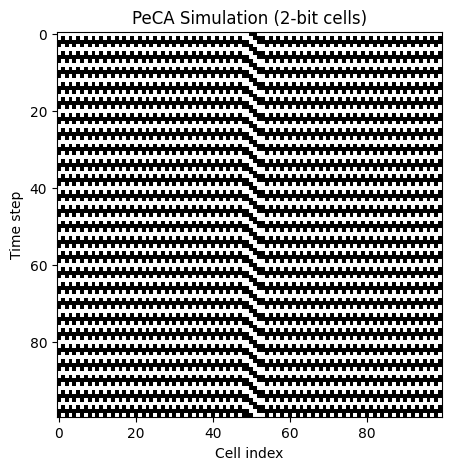

In [ ]:
# Example run

# Define the permutation you want to use
perm = [1, 0, 3, 2]  # any valid permutation of 4 elements

# Convert permutation to rule number
rule_number = permutation_to_int(perm)

# Run simulation
sim = simulate_peca(rule_number=rule_number, size=50, steps=100)

# Visualize the result
visualize_peca(sim)

# Visual Comparison of PeCA Rules: 0, 1, 8, and 22

To explore the diversity of behaviors in 2-bit Permutational Cellular Automata (PeCA), we present a side-by-side visualization of four representative rules:

* Rule 0: Identity permutation — cells remain static (Class I).

* Rule 1: Simple growth — generates a basic expanding pattern (Class II).

* Rule 8: Clock-like behavior — acts as a base-3 counter (periodic, Class II).

* Rule 22: Fractal-like structure — shows complex, self-similar growth (borderline Class IV).

All rules are simulated from the same initial condition: a central cell in state [1, 1], surrounded by [0, 0] elsewhere. Simulations are run on a 50-cell ring for 100 time steps, using periodic boundary conditions.

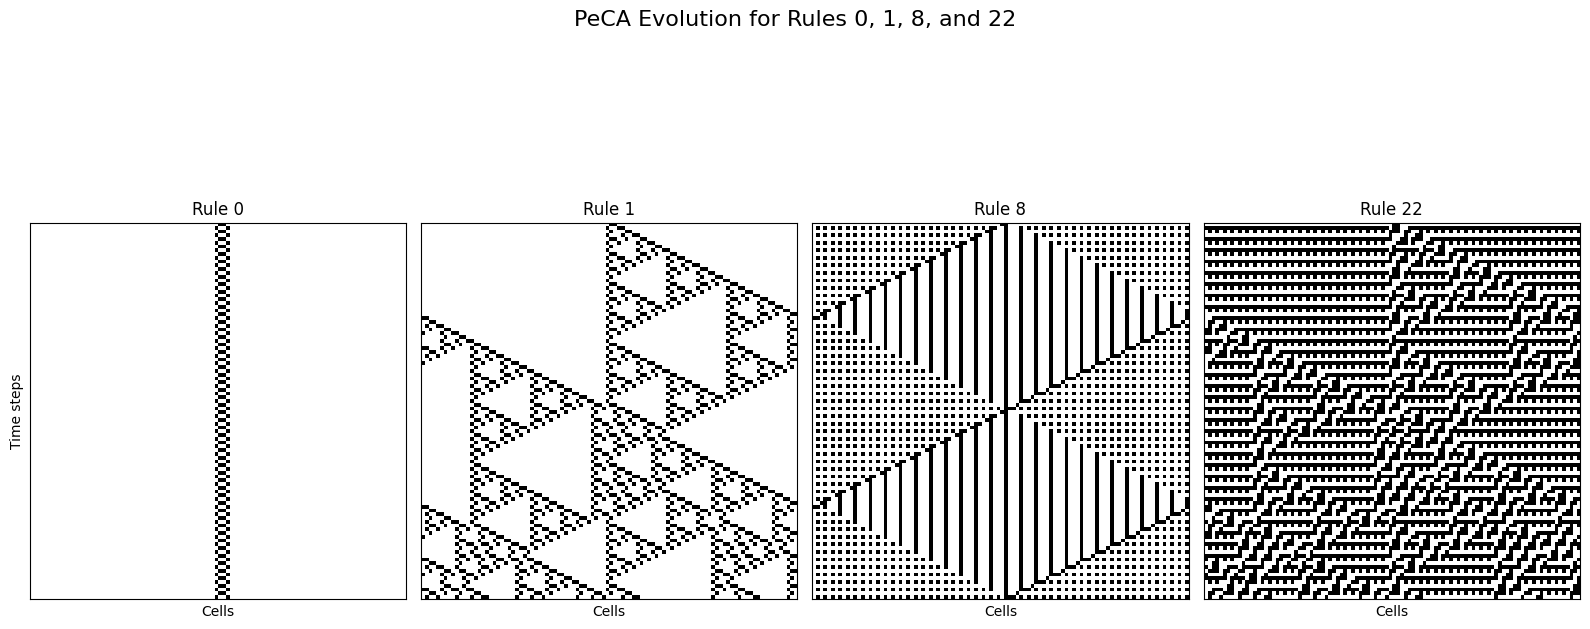

In [ ]:
# Rule numbers to visualize
rule_nums = [0, 1, 8, 22]
rule_perms = [int_to_permutation(n, 4) for n in rule_nums]
labels = [f"Rule {n}" for n in rule_nums]

# Simulate each
sims = [simulate_peca(rule_number=n, size=50, steps=100) for n in rule_nums]

# Plot all
fig, axes = plt.subplots(1, 4, figsize=(16, 8), sharey=True)
for ax, sim, label in zip(axes, sims, labels):
    img = np.zeros((sim.shape[0], sim.shape[1] * 2))
    for t in range(sim.shape[0]):
        for i in range(sim.shape[1]):
            img[t, 2 * i:2 * i + 2] = sim[t, i]
    ax.imshow(img, cmap="Greys", interpolation="none")
    ax.set_title(label)
    ax.set_xlabel("Cells")
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].set_ylabel("Time steps")
plt.suptitle("PeCA Evolution for Rules 0, 1, 8, and 22", fontsize=16)
plt.tight_layout()
plt.show()


## Interactive PeCA Simulator (m = 2)

This widget allows you to explore the behavior of Permutational Cellular Automata (PeCA) with 2-bit cells by customizing simulation parameters.

You can configure:

- **Size**: Total number of cells in the 1D array.
- **Rule #**: A number between 0 and 23 identifying the permutation rule used for state updates.
- **Pattern**: Initial state pattern (e.g., `11`, `01`, etc.) that is placed in the center of the array.
- **Fill**: Bit value (`0` or `1`) used to initialize all other cells outside the pattern.

Click **Start** to simulate the automaton for 100 time steps and visualize the evolution over time. Each cell is shown using two pixels (one per bit), with white for `0` and black for `1`.

Use this tool to experiment with different initial conditions and rules, and observe how complexity emerges from simple permutations.

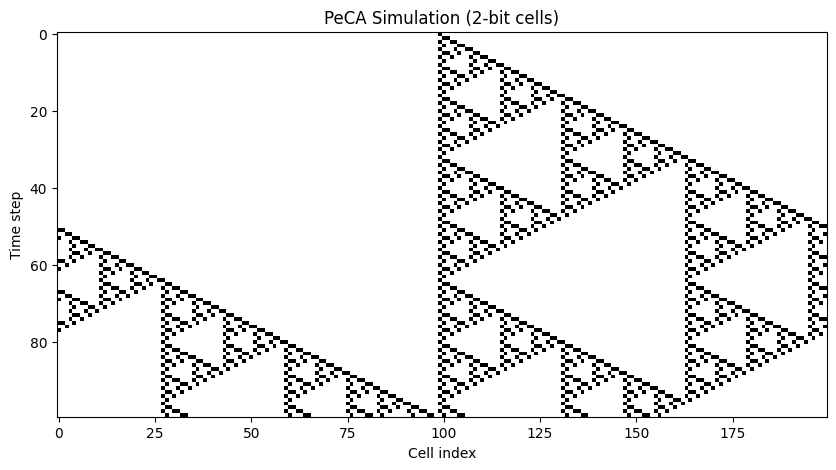

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def run_interactive_peca(size, rule_number, pattern_str, fill_bit):
    # Validaciones
    if size % 1 != 0 or size <= 0:
        print("Size must be a positive integer.")
        return

    # Convertir patrón a lista de bits
    try:
        pattern = [int(b) for b in pattern_str.strip() if b in '01']
    except ValueError:
        print("Pattern must be a string of bits, like '11' or '01'")
        return

    if len(pattern) % 2 != 0:
        print("Pattern must be a multiple of 2 (since m=2)")
        return

    full_len = 2 * size
    init_state = [fill_bit] * full_len
    mid = full_len // 2
    pat_len = len(pattern)
    start = mid - pat_len // 2
    init_state[start:start + pat_len] = pattern

    # Simulación
    sim = simulate_peca(rule_number, size=size, steps=100, init_state=init_state)
    visualize_peca(sim)

# Widgets
size_slider = widgets.IntSlider(value=50, min=10, max=200, step=2, description='Size:')
rule_slider = widgets.IntSlider(value=0, min=0, max=23, step=1, description='Rule #:')
pattern_input = widgets.Text(value='11', description='Pattern:')
fill_dropdown = widgets.Dropdown(options=[(0, 0), (1, 1)], value=0, description='Fill:')
run_button = widgets.Button(description="Start", button_style='success')

def on_run_clicked(b):
    clear_output(wait=True)
    display(ui)
    run_interactive_peca(
        size_slider.value,
        rule_slider.value,
        pattern_input.value,
        fill_dropdown.value
    )

run_button.on_click(on_run_clicked)

# Layout
ui = widgets.VBox([
    widgets.HTML("<h3>PeCA Simulator (m=2)</h3>"),
    size_slider,
    rule_slider,
    pattern_input,
    fill_dropdown,
    run_button
])

display(ui)

## Closing Remarks

This notebook has explored a simple but powerful class of reversible cellular automata: **Permutational Cellular Automata (PeCA)** with 2-bit cells.

We have:

- Introduced the encoding tools linking permutations, integers, and factoradic numbers.
- Defined how local update rules act via permutations over binary states.
- Implemented the connectivity structure for PeCA with `m = 2`.
- Visualized the evolution of rules from Wolfram's Class I to Class IV behaviors.
- Built an **interactive simulator** to explore rule dynamics from custom initial conditions.

These tools provide an accessible playground for investigating reversible, bitwise automata—and a basis for further work, including **quantum extensions**, as discussed in the accompanying paper:

> **Permutational Cellular Automata: From Bitwise Reversibility to Quantum Dynamics**  
> Joaquín Cerdá-Boluda & Marta C. Mora

You can find the full implementation, simulations, and extended tools in the GitHub repository:  
🔗 [github.com/ximocerda/PermutationalCellularAutomata](https://github.com/ximocerda/PermutationalCellularAutomata)

We invite you to fork, extend, and experiment!

---

📬 *For feedback or collaboration inquiries, feel free to open an issue or reach out via GitHub.*
